This comparison is based on the following publication: https://www.kaggle.com/code/ghaithmechi/optical-caracter-recognition-ocr

In [104]:
# Imports
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
plt.style.use('ggplot')
import cv2
import easyocr
import imutils

In [21]:
# Explore dataset
annot=pd.read_parquet('dataset/annot.parquet')
annot.head()

,id,image_id,bbox,utf8_string,points,area
0,a4ea732cd3d5948a_1,a4ea732cd3d5948a,"[525.83, 3.4, 197.64, 33.94]",Performance,"[525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...",6707.90
1,a4ea732cd3d5948a_2,a4ea732cd3d5948a,"[534.67, 64.68, 91.22, 38.19]",Sport,"[535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...",3483.69
2,a4ea732cd3d5948a_3,a4ea732cd3d5948a,"[626.95, 63.62, 96.52, 31.82]",Watch,"[626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...",3071.27
3,a4ea732cd3d5948a_4,a4ea732cd3d5948a,"[577.4, 141.87, 147.13, 43.1]",...period.,"[580.02, 143.61, 724.53, 141.87, 723.66, 184.9...",6341.30
4,a4ea732cd3d5948a_5,a4ea732cd3d5948a,"[391.03, 163.9, 60.82, 38.65]",.,"[395.2, 163.9, 451.85, 191.94, 445.59, 202.55,...",2350.69


In [9]:
images=pd.read_parquet('dataset/img.parquet')
images.head()

,id,width,height,set,file_name
0,a4ea732cd3d5948a,840,1024,train,train/a4ea732cd3d5948a.jpg
1,4bf43a7b2a898044,1024,683,train,train/4bf43a7b2a898044.jpg
2,1b55b309b0f50d02,1024,683,train,train/1b55b309b0f50d02.jpg
3,00c359f294f7dcd9,1024,680,train,train/00c359f294f7dcd9.jpg
4,04b5a37f762b0f51,768,1024,train,train/04b5a37f762b0f51.jpg


['LIDER/MARCELLIONO' '·THE' 'WAINSCOTT' 'WEASEL·' 'ATHENIUM' 'A' 'SEIDLER'
 'BORN' '.' 'SELDEN' 'THE' 'CRICKET' 'IN' 'TIMES' '.' 'DAN' 'R' 'DES'
 'USE' 'OF' 'OLYMPU' '.' 'SCOTT' '.' 'DL' 'RAMAR' 'D' 'MAR']


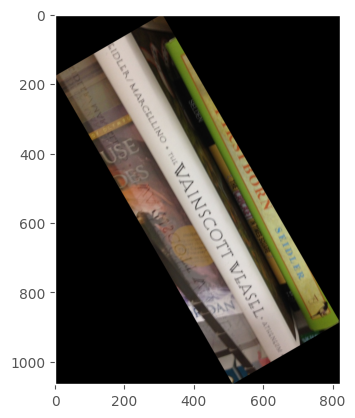

In [118]:
def get_image(idx):
    image_id=images.iloc[idx].id
    image_path = f"dataset/train_val_images/train_images/{image_id}.jpg"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_annot = annot.query("image_id == @image_id")
    texts = image_annot["utf8_string"].values
    
    return image, texts

def rotate_image(image):
    results = []
    results.append(image)
    for angle in [15, 30, 45, 60, 75, 90, -15, -30, -45, -60, -75, -90]:
        results.append(imutils.rotate_bound(image, angle))
    return results

plt.grid(None)
image, texts = get_image(9)
image = rotate_image(image)[8]
plt.imshow(image)
print(texts)

Dataset: {'.', 'performance', '170', '30', '12', '65', '20', '40', '45', 'sport', '400', 'watch', '15', 'gtor®', '10', '300', '60', '100', '50', '...period.'}
EasyOCR: {'"perlod:', 'i!', '3', 'gtr', '6', '1', 'period:', 'performance', '5l', 'b', '45', '8', 'sport', "'", '{', 'watch', "'period:", '@tor', '5[', '1|', 's', '15', 'l', 'perlod:', "sport'", 'gtor', '5', '@tob'}
Matches: ['performance', '45', 'sport', 'watch', '15']
Accuracy: 0.25


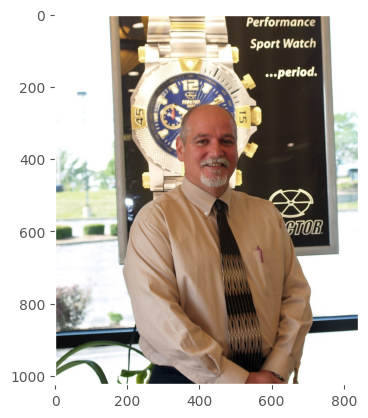

In [127]:
def predict_easyocr(image):
    easyocr_reader = easyocr.Reader(['en'])
    all_texts = []
    for im in rotate_image(image):
        texts = easyocr_reader.readtext(im, detail=0)
        texts = [pred.split() for pred in texts]
        texts = [item for sublist in texts for item in sublist]
        all_texts.extend(texts)
    all_texts = [i.lower() for i in all_texts]
    all_texts = list(set(all_texts))
    return all_texts

def compare_easyocr_output(expect_output, easyocr_output, log=False):
    expect_output = set([i.lower() for i in expect_output])
    easyocr_output = set([i.lower() for i in easyocr_output])
    if log:
        print(f"Dataset: {expect_output}")
        print(f"EasyOCR: {easyocr_output}")
    # Compare matching percentage
    matches_count = 0
    matches_text = []
    for i in expect_output:
        if i in easyocr_output:
            matches_count += 1
            matches_text.append(i)
    accuracy = matches_count / len(expect_output)
    if log:
        print(f"Matches: {matches_text}")
        print(f"Accuracy: {accuracy}")
    return accuracy, matches_text
    

image, expected_output = get_image(0)
easyocr_output = predict_easyocr(image)
compare_easyocr_output(expected_output, easyocr_output, log=True)
plt.imshow(image)
plt.grid(None)